In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import airy
from scipy.integrate import odeint

In [2]:
#konstante

AA=8.6375   #m/hbar
BB=13.12    #m/hbar**2
hbar=AA/BB
m=AA*hbar

V0=0.5 #parametar V0 u eV
a=2



Text(0.5, 1.0, 'Potencijal')

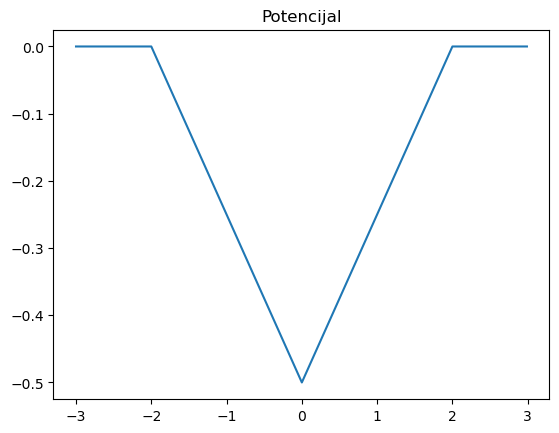

In [3]:
def potencijal(x):
    if np.abs(x) > a:
        return 0
    else:
        return V0/a*(np.abs(x)-a)
    
xmesh = np.arange(-1.5*a, 1.5*a, 0.01)
V = [potencijal(x) for x in xmesh]
plt.plot(xmesh, V)
plt.title('Potencijal')

# Analitički

In [4]:
#Analitički koeficijenti

def koef(E, k):
    #k = np.sqrt(2*m*E/hbar**2)
    gamma = -E*(2*m*a**2/(hbar*V0)**2)**(1/3)
    delta = -(V0+E)*(2*m*a**2/(hbar*V0)**2)**(1/3)
    ro = k*(hbar**2*a/2/m/V0)**(1/3)
    G = 1 + 0j
    p = airy(gamma)
    q = airy(delta)
    Aiy = p[0]
    dAiy = p[1]
    Biy = p[2]
    dBiy = p[3]
    Aid = q[0]
    dAid = q[1]
    Bid = q[2]
    dBid = q[3]
    
    F = G*(ro*1j*Biy-dBiy)/(dAiy - ro*1j*Aiy)
    D = (-2*F*dAid*Aid-G*(Aid*dBid+dAid*Bid))/(dBid*Aid-dAid*Bid)
    C = (F*Aid+G*Bid-D*Bid)/Aid
    A = np.exp(1j*k*a)/2*(C*Aiy+C*1j/ro*dAiy + D*Biy + D*1j/ro*dBiy)
    B = np.exp(-1j*k*a)/2*(C*Aiy-C*1j/ro*dAiy + D*Biy - D*1j/ro*dBiy)
    T = np.exp(-1j*k*a)*(F*Aiy+G*Biy)
    return A, B, C, D, F, G, T

# Numerički

In [5]:
#Numerika

Xmin=-3*a  
Xmax= 3*a   
step=0.01   
xmesh=np.arange(Xmax,Xmin,-step)    #ukupna mreza
#V = [potencijal(x) for x in xmesh]
Npts=len(xmesh)

In [6]:
#fja za odeint
def func(y,x,e):
    v=potencijal(x)
    f1R=y[0]
    f1I=y[1]
    f2R=y[2]
    f2I=y[3]
    fac1=f2R
    fac2=f2I
    fac3=-2*m*(e-v)*f1R/hbar**2
    fac4=-2*m*(e-v)*f1I/hbar**2
    return [fac1,fac2,fac3,fac4]

#raspon energija
Emin=0.0001
Emax=1.5*V0
dE=(Emax-Emin)/500
energija=np.arange(Emin,Emax,dE)

In [7]:
#izračun koeficijenata refleksije i transmisije

tkoef=[]
rkoef=[]
T_analit=[]
R_analit=[]

for E in energija:
    k=np.sqrt(2*m*E)/hbar
    K = koef(E, k)
    y0=[np.cos(k*Xmax),np.sin(k*Xmax),-k*np.sin(k*Xmax),k*np.cos(k*Xmax)] 
    y=odeint(func,y0,xmesh,args=(E,))
    yR=y[Npts-1,0]
    yI=y[Npts-1,1]
    dyR=y[Npts-1,2]
    dyI=y[Npts-1,3]
    c=np.cos(k*Xmin)
    s=np.sin(k*Xmin)
    ks=k*s
    kc=k*c
    A=np.zeros([4,4],float)
    b=np.zeros([4],float)
    A[0,0]=c
    A[0,1]=-s
    A[0,2]=c
    A[0,3]=s
    A[1,0]=s
    A[1,1]=c
    A[1,2]=-s
    A[1,3]=c
    A[2,0]=-ks
    A[2,1]=-kc
    A[2,2]=-ks
    A[2,3]=kc
    A[3,0]=kc
    A[3,1]=-ks
    A[3,2]=-kc
    A[3,3]=-ks
    b[0]=yR
    b[1]=yI
    b[2]=dyR
    b[3]=dyI

    sol=np.linalg.solve(A,b)
    AR=sol[0]
    AI=sol[1]
    BR=sol[2]
    BI=sol[3]
    
    tkoef.append(1/(AR**2+AI**2))
    rkoef.append((BR**2+BI**2)/(AR**2+AI**2))
    T_analit.append((np.abs(K[6]/K[0]))**2)
    R_analit.append((np.abs(K[1]/K[0]))**2)
    
    
tkoef=np.array(tkoef)
rkoef=np.array(rkoef)

# Plot i usporedba

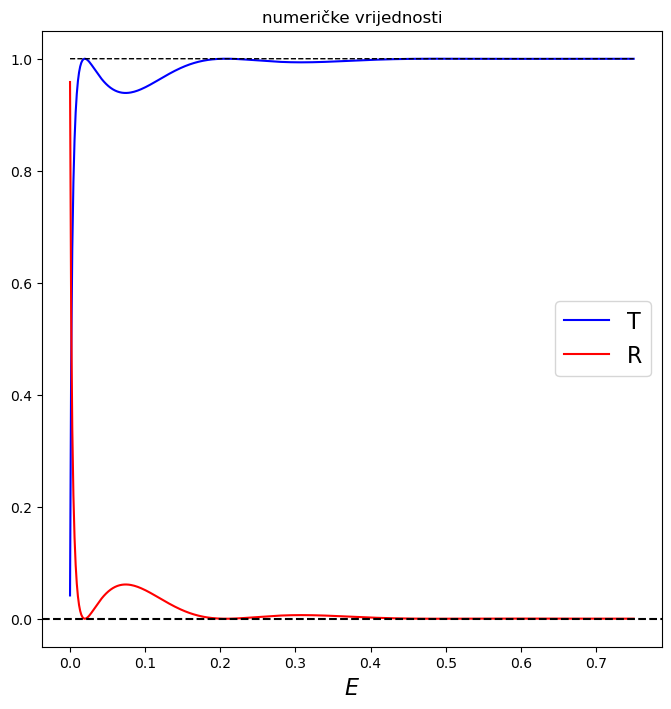

In [8]:
#plot koeficijenata
fig1=plt.figure(1,figsize=(8,8))

plt.plot(energija,tkoef,color='blue',lw=1.5,label='T')
plt.plot(energija,rkoef,color='red',lw=1.5,label='R')
plt.plot(energija,rkoef+tkoef,color='k',ls='--',lw=1)
plt.legend(fontsize=16)
plt.xlabel(r'$E$',size=16)
plt.title('numeričke vrijednosti')

plt.axhline(y=0, ls='--', color='black')

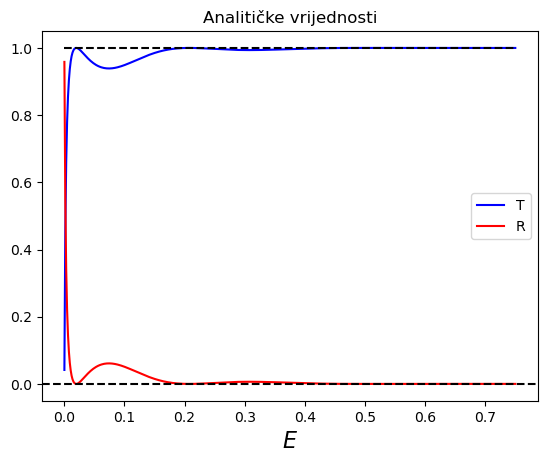

In [9]:
T_analit = np.array(T_analit)
R_analit = np.array(R_analit)
plt.plot(energija, T_analit, color ='blue', label='T')
plt.plot(energija, R_analit, color='red', label = 'R')
plt.plot(energija, T_analit+R_analit, ls='--', color = 'black')
plt.legend()
plt.title('Analitičke vrijednosti')
plt.xlabel(r'$E$',size=16)
plt.axhline(y=0, ls='--', color='black')

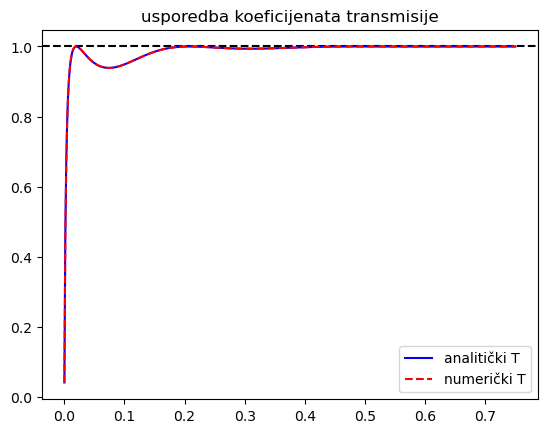

In [10]:
plt.axhline(y=1, ls='--', color = 'black')
plt.plot(energija, T_analit, color = 'blue', label='analitički T')
plt.plot(energija, tkoef, ls='--', label = 'numerički T', color = 'red')
plt.title('usporedba koeficijenata transmisije')
plt.legend()



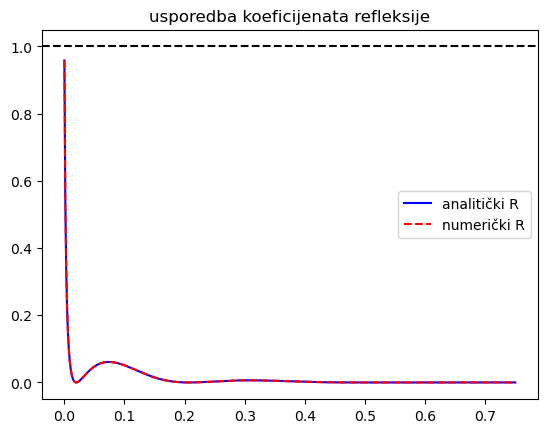

In [11]:
plt.axhline(y=1, ls='--', color = 'black')
plt.plot(energija, R_analit, color = 'blue', label='analitički R')
plt.plot(energija, rkoef, ls='--', label = 'numerički R', color = 'red')
plt.title('usporedba koeficijenata refleksije')
plt.legend()

# Pravokutna jama

In [12]:
#potencijal
def pravokutna(E):
    k1=np.sqrt(2*m*E)/hbar
    k2=np.sqrt(2*m*(E+V0))/hbar
    return 16*k1**2*k2**2/(16*k1**2*k2**2 + 4*(k1**2-k2**2)**2*(np.sin(k2*2*a))**2)

In [13]:
#koeficijenti
t_prav=[pravokutna(e) for e in energija]
r_prav=[1 - t for t in t_prav]


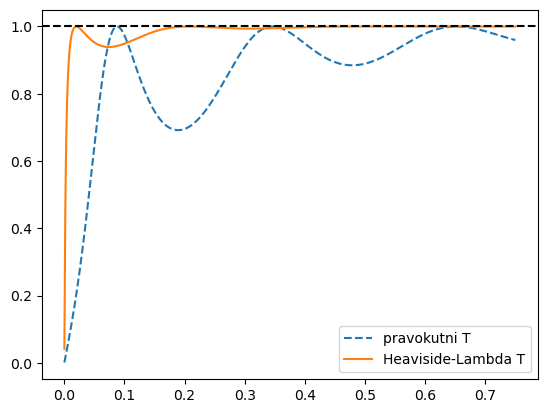

In [16]:
#usporedba koeficijenata

plt.plot(energija, t_prav, label = 'pravokutni T', ls = '--')
plt.plot(energija, tkoef, label = 'Heaviside-Lambda T')
plt.legend()
plt.axhline(y=1, ls='--', color = 'black')


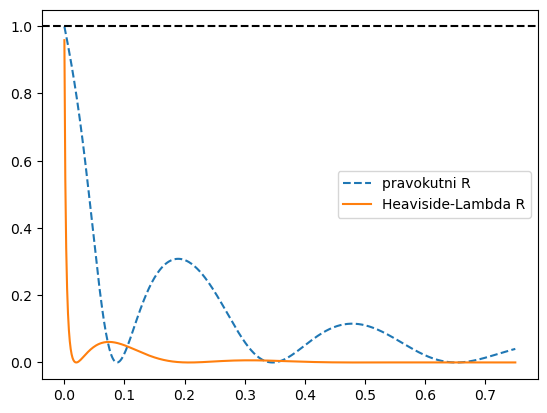

In [15]:
#usporedba koeficijenata

plt.plot(energija, r_prav, label = 'pravokutni R', ls='--')
plt.plot(energija, rkoef, label = 'Heaviside-Lambda R')
plt.legend()
plt.axhline(y=1, ls='--', color = 'black')


Usporedba:

Obje jame pokazuju interferenciju, no kod pravokutne je izraženija. Također, kod Heaviside-Lambda jame koeficijenti brže "trnu", tj refleksija brže ide u nulu, a transmisija brže u 1